# Here we try to use a median across time to estimate the pattern (my background)

In [47]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../lib/PythonGbinReader/GbinReader/'))
import gbin_reader

In [49]:
from astropy.io import fits
import astroscrappy
from matplotlib.colors import LogNorm
import scipy.ndimage as ndimage

In [50]:
gain=3.853           # gain [e-/ADU]
readnoise=8.365785291814616 # readout noise [e-]
bias=2576            # bias [ADU]

In [538]:
# Read in a BamObservation gbin file
nsource = 20
data_file='../../datasets/gbins/bam/2017-07-02/BamObservation_000-000-{:03d}.gbin'.format(nsource)

#nsource = 10
#data_file='../../datasets/gbins/bam/09-2017/BamObservation_000-000-{:03d}.gbin'.format(nsource) # this one is from the flare

reader = gbin_reader.GbinReader(data_file)
bamObs = reader.__next__()

In [539]:
print("")
print("BAM FOV             : %s" % bamObs.fov)
print("BAM AC Coordinate   : %s" % bamObs.ac)   
print("BAM Acquistion Time : %s" % bamObs.acqTime)
print("BAM Acquistion Row  : %s" % bamObs.ccdRow)
print("BAM Number of Packet: %s" % bamObs.numPackets)
print("BAM Obs. SolutionId : %s" % bamObs.solutionId)
print("BAM Nb. of  Samples : %s" % len(bamObs.samples))
print("")
print(" --> Each BAM TM Packet is transformed into one BamObservation object.")
print(" --> Each BamObservation contain 2 BAM patterns.")
print(" --> A BAM pattern is 500 (Along Scan - AL) x 80 (Across Scan - AC) samples = 40000.")
print("")


BAM FOV             : 1
BAM AC Coordinate   : 473
BAM Acquistion Time : 115878556039129100
BAM Acquistion Row  : 1
BAM Number of Packet: 2
BAM Obs. SolutionId : 3158430714639155200
BAM Nb. of  Samples : 80000

 --> Each BAM TM Packet is transformed into one BamObservation object.
 --> Each BamObservation contain 2 BAM patterns.
 --> A BAM pattern is 500 (Along Scan - AL) x 80 (Across Scan - AC) samples = 40000.



In [540]:
pattern = ((np.array(bamObs.samples).reshape((1000,80)))).astype("float64")

Let's look at the pattern:

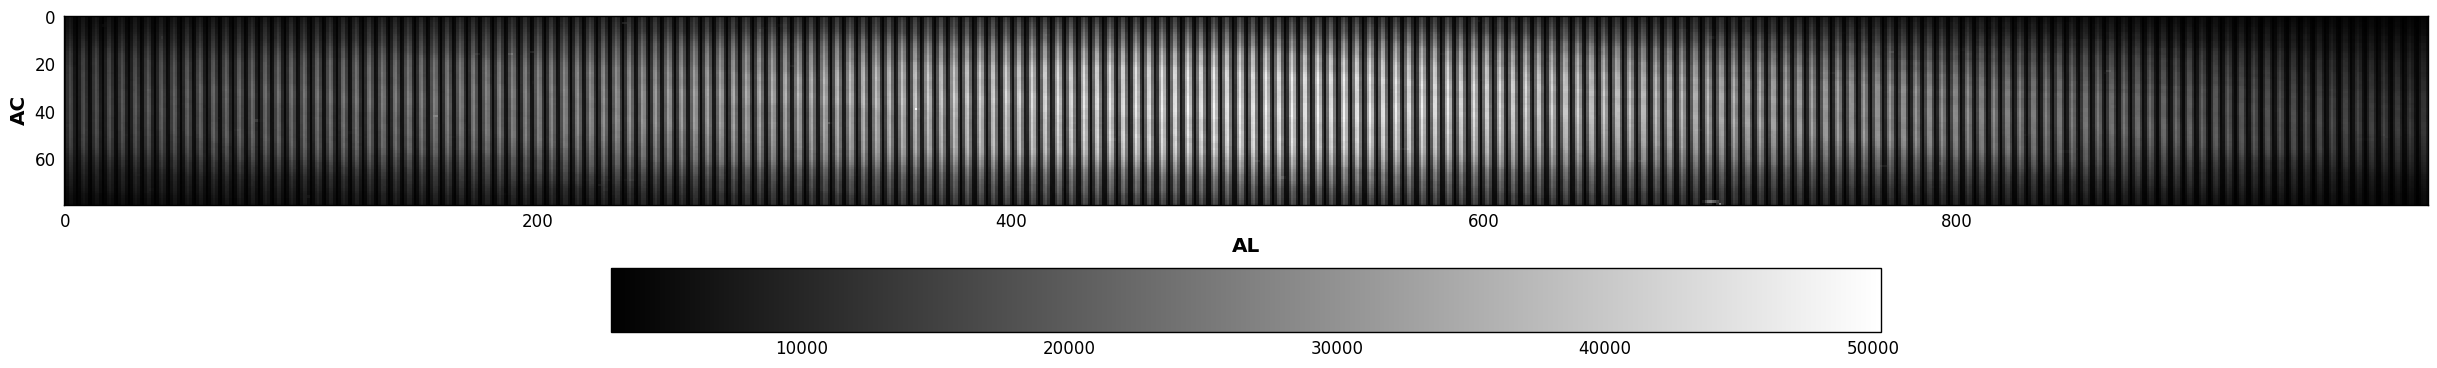

In [541]:
image=np.rot90(pattern,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

Now do the boxcar

In [658]:
boxrad = 3  # take the +- boxrad images

patterns = np.empty((2*boxrad+1,1000,80,))
patterns[boxrad] = pattern
fov = bamObs.fov

First previous samples, then later samples

In [659]:
ii = 1 # running index
n = 0   # number of samples gathered
    
while n < boxrad:
    temp_file='../../datasets/gbins/bam/07-2017/BamObservation_000-000-{:03d}.gbin'.format(nsource-ii)
    #temp_file='../../datasets/gbins/bam/09-2017/BamObservation_000-000-{:03d}.gbin'.format(nsource-ii)  # flare
    tempreader = gbin_reader.GbinReader(data_file)
    tempObs = reader.__next__()
    if tempObs.fov == fov:
        n += 1
        patterns[boxrad-n] = (np.array(tempObs.samples).reshape((1000,80))).astype("float64")
        print(nsource-ii, tempObs.fov)
        
    ii += 1

18 1
16 1
14 1


In [660]:
ii = 1 # running index
n = 0   # number of samples gathered
    
while n < boxrad:
    temp_file='../../datasets/gbins/bam/07-2017/BamObservation_000-000-{:03d}.gbin'.format(nsource+ii)
    #temp_file='../../datasets/gbins/bam/09-2017/BamObservation_000-000-{:03d}.gbin'.format(nsource+ii)  # flare
    tempreader = gbin_reader.GbinReader(data_file)
    tempObs = reader.__next__()
    if tempObs.fov == fov:
        n += 1
        patterns[boxrad+n] = (np.array(tempObs.samples).reshape((1000,80))).astype("float64")
        print(nsource+ii, tempObs.fov)
        
    ii += 1

22 1
24 1
26 1


Bias and Gain

In [661]:
patterns = (patterns-bias)*gain

In [662]:
#background = np.median(patterns,axis=0)

In [663]:
from astropy.stats import sigma_clip
no_cosm = sigma_clip(patterns,sigma=2,iters=None,axis=0)
background = np.mean(no_cosm, axis=0)

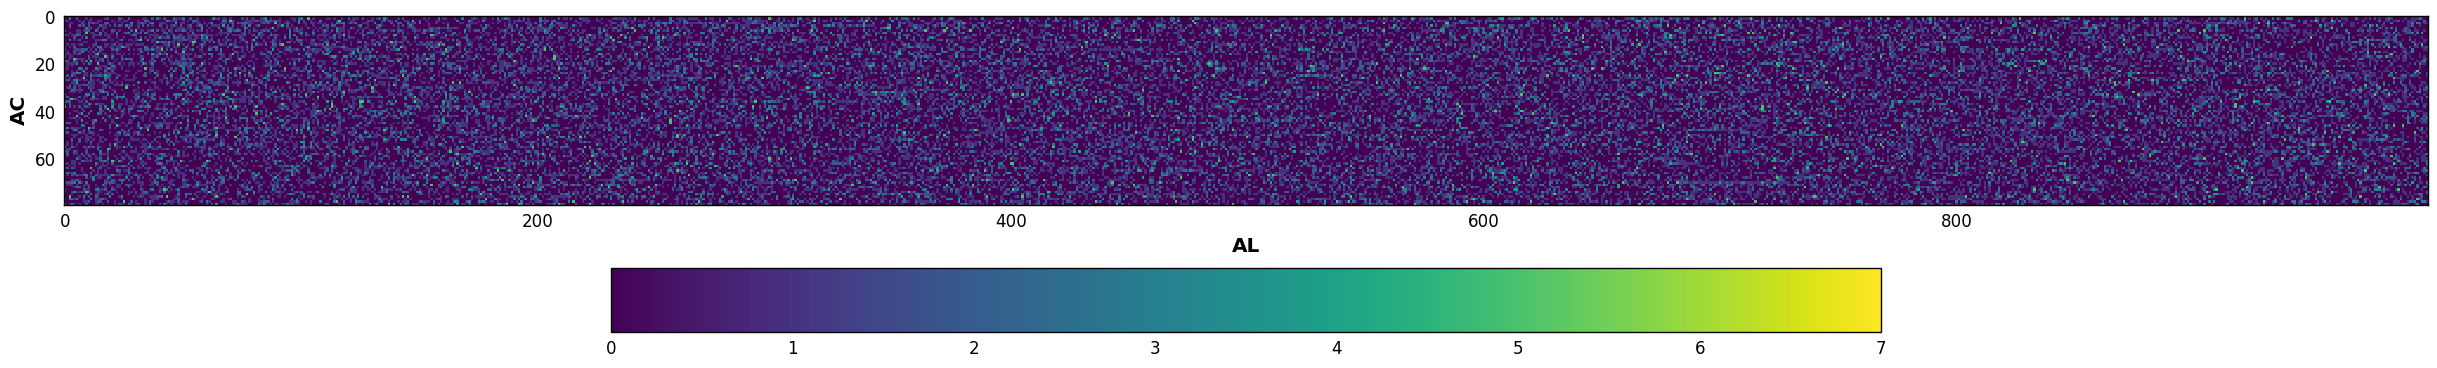

In [664]:
image=np.rot90(np.sum(no_cosm.mask.astype("int"),axis=0),1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image,vmin=0,vmax=2*boxrad+1)
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

#mhist = plt.hist((np.sum(no_cosm.mask.astype("int"),axis=0).flatten()),5)

In [703]:
np.argwhere((np.sum(no_cosm.mask.astype("int"),axis=0)>4))

array([[  0,  41],
       [  2,   3],
       [  3,  44],
       ..., 
       [995,   2],
       [995,  56],
       [997,  67]])

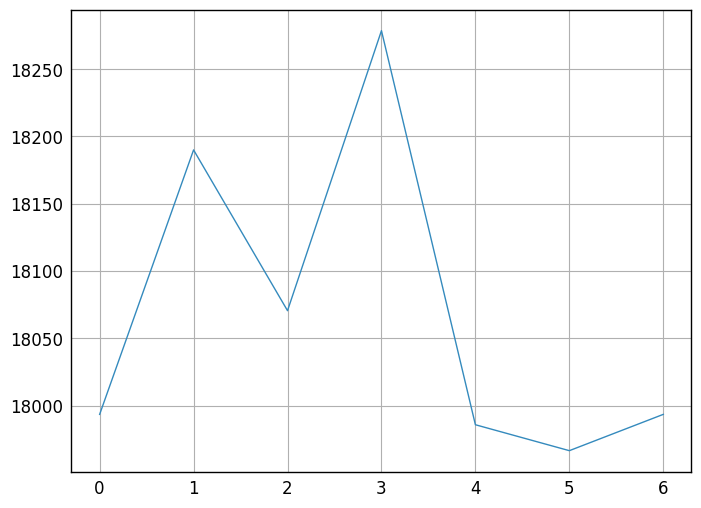

In [704]:
plt.plot(patterns[:,997,67])

In [667]:
signal = patterns[boxrad] - background

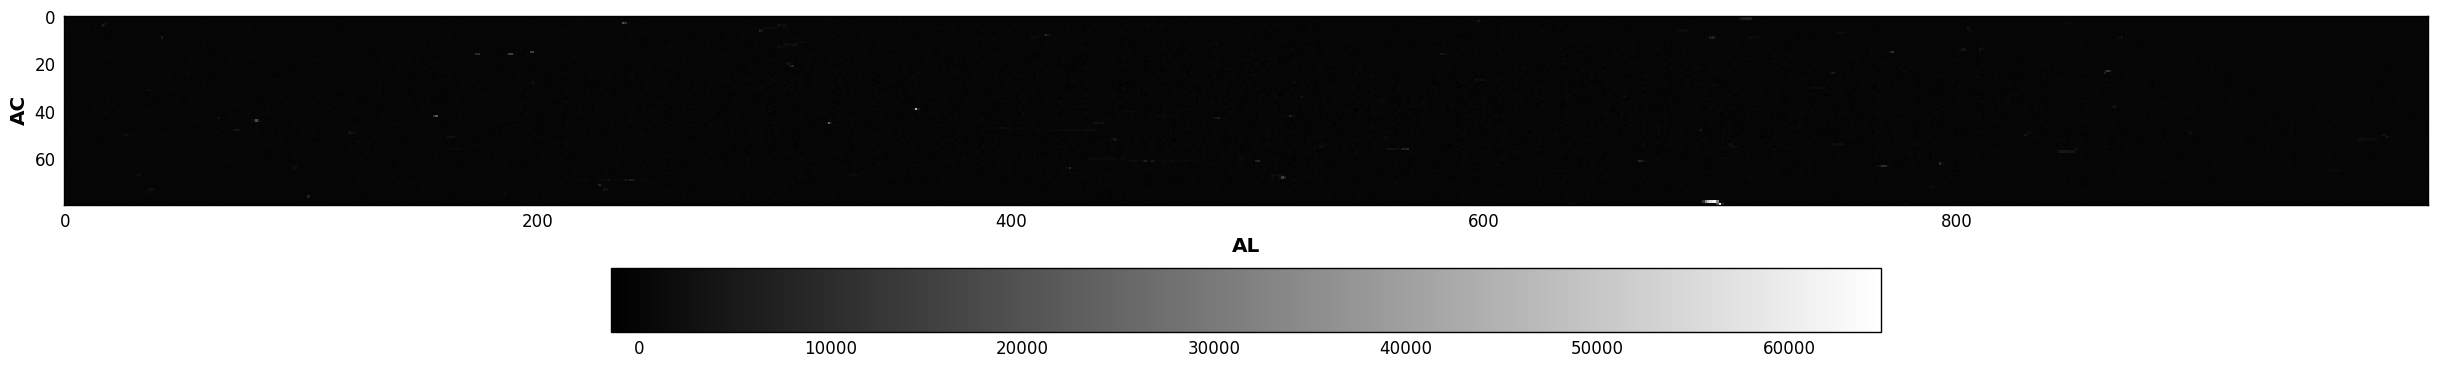

In [668]:
image=np.rot90(signal,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

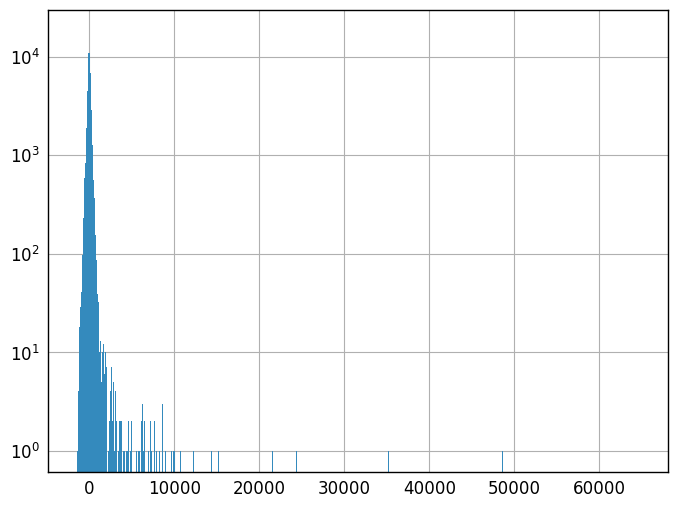

In [669]:
histo = plt.hist(signal.flatten(),1000,log=True)

In [670]:
source = np.copy(signal)

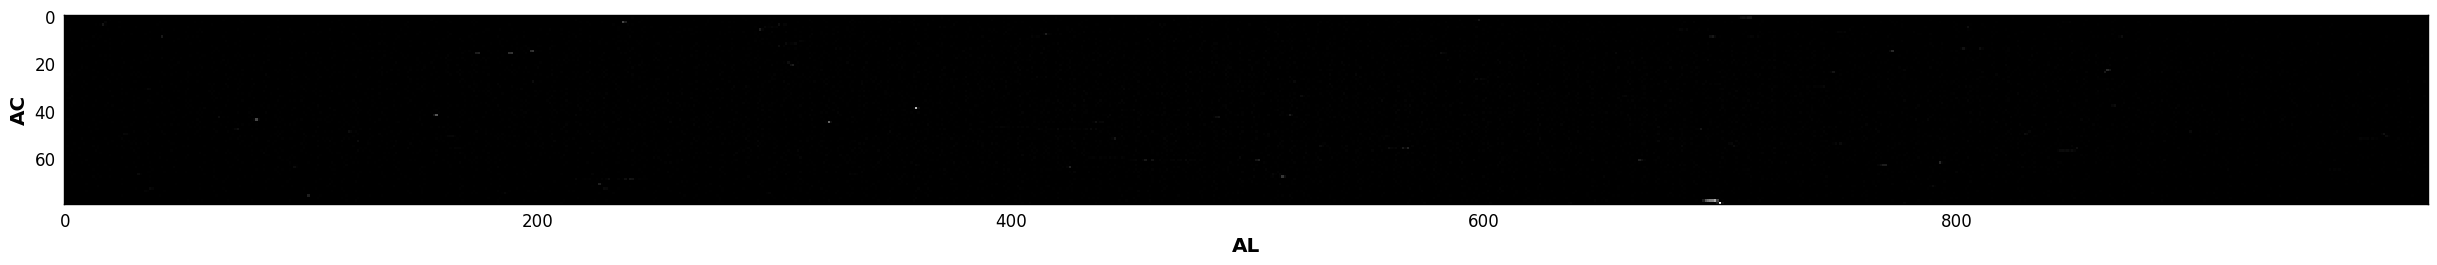

In [671]:
# Laplacian filter

lp = astroscrappy.subsample((source).astype("float32"))
lp = astroscrappy.laplaceconvolve(lp)
lp [lp<0] = 0      # clipping
lp = astroscrappy.rebin(lp)

image=np.rot90(lp,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.grid(False)

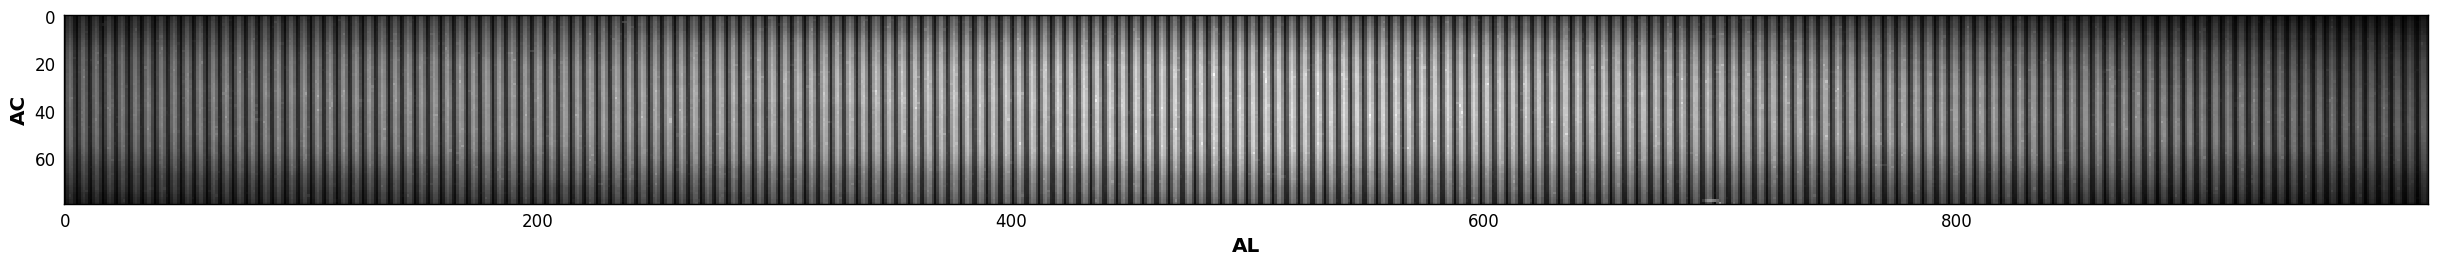

In [672]:
# Noise map

# for this, we use OUR OWN estimate of the noise!

#noise = np.sqrt(patterns[boxrad] + background + readnoise*readnoise)
# this is poisson noise in signal pattern, poissonian of background and readnoise
# NOTE: the treatment of the background may have to be different!

# from my error estimation:
err_mean = np.zeros(source.shape)

(xmax, ymax) = source.shape
N_time = (2*boxrad+1)-np.sum(no_cosm.mask.astype("int"),axis=0)

var_mean = (readnoise*readnoise + np.sum(no_cosm,axis=0)/N_time)/N_time       # from error propagation
err_mean = np.sqrt(var_mean + readnoise*readnoise + patterns[boxrad,:,:])     # total error, for every pixel

noise = np.copy(err_mean)

image=np.rot90(noise,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.grid(False)

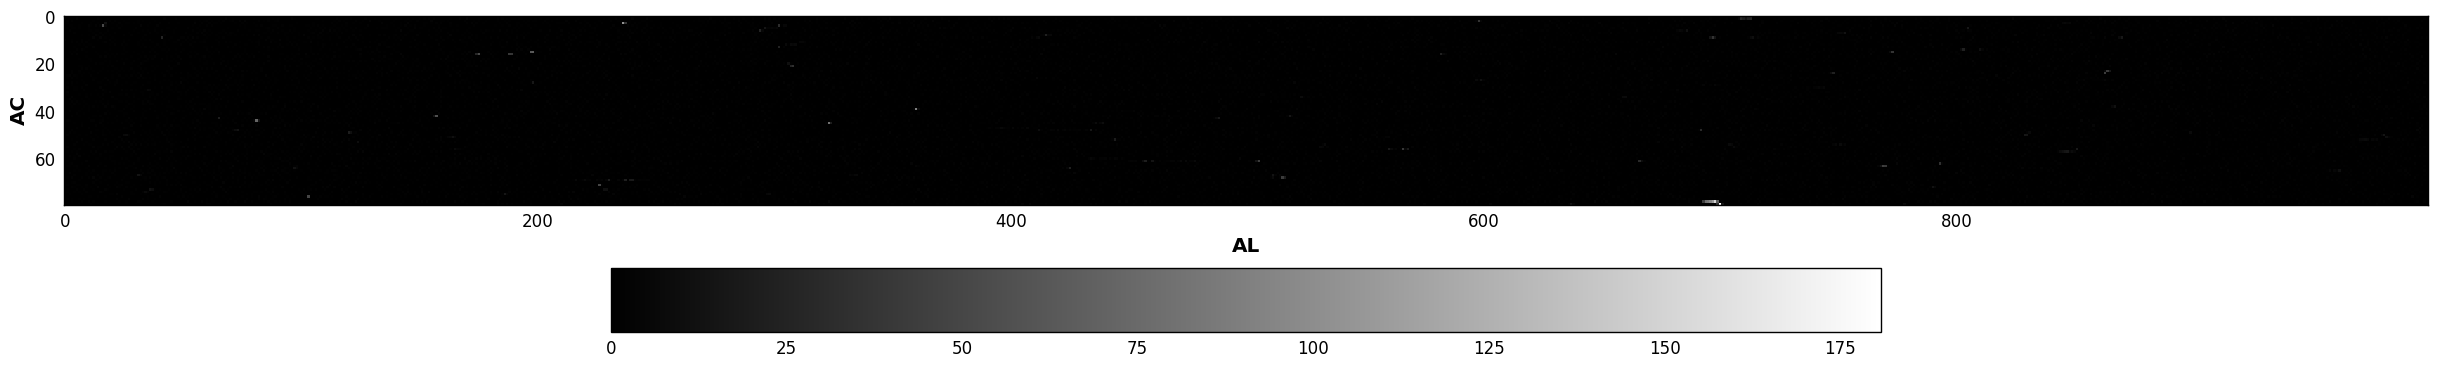

In [673]:
# weigh by noise

S = lp/2/noise

image=np.rot90(S,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.colorbar(orientation="horizontal")
plt.grid(False)

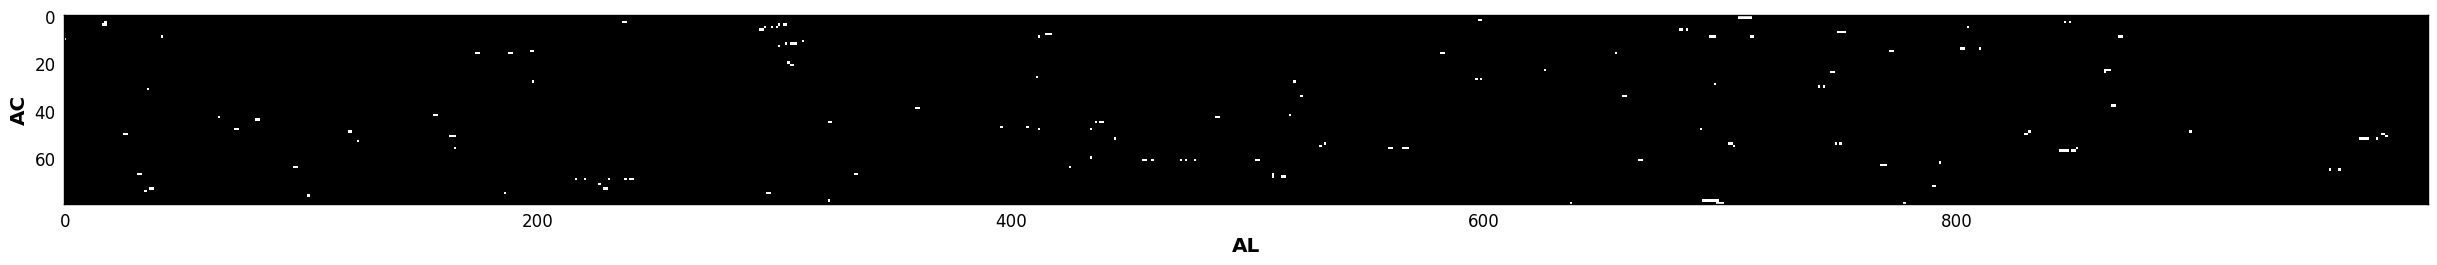

In [674]:
# remove sampling flux - this is now the first criterion

Sp = S - astroscrappy.medfilt5(S.astype("float32"))

# for now, let's just use S though - I don't expect any stars here
stest = np.copy(S)
sigclip = 4.5

stest[S<sigclip] = 0
stest[S>=sigclip] = 1


image=np.rot90(stest,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

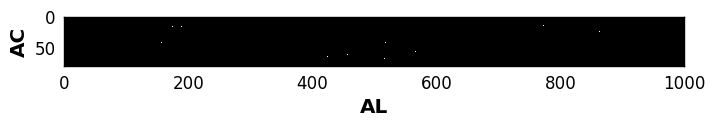

In [675]:
# fine structure image

f = astroscrappy.medfilt3((source).astype("float32"))
f = (f - astroscrappy.medfilt7(f)) / noise
f[f < 0.01] = 0.01     # clipping

objlim = 1000          # this is not helping in any way
ftest = Sp / f         # the second criterion

ftest[(Sp / f)<objlim]=0
ftest[(Sp / f)>=objlim]=1


image=np.rot90(ftest,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

For now, build your mask based on S alone.


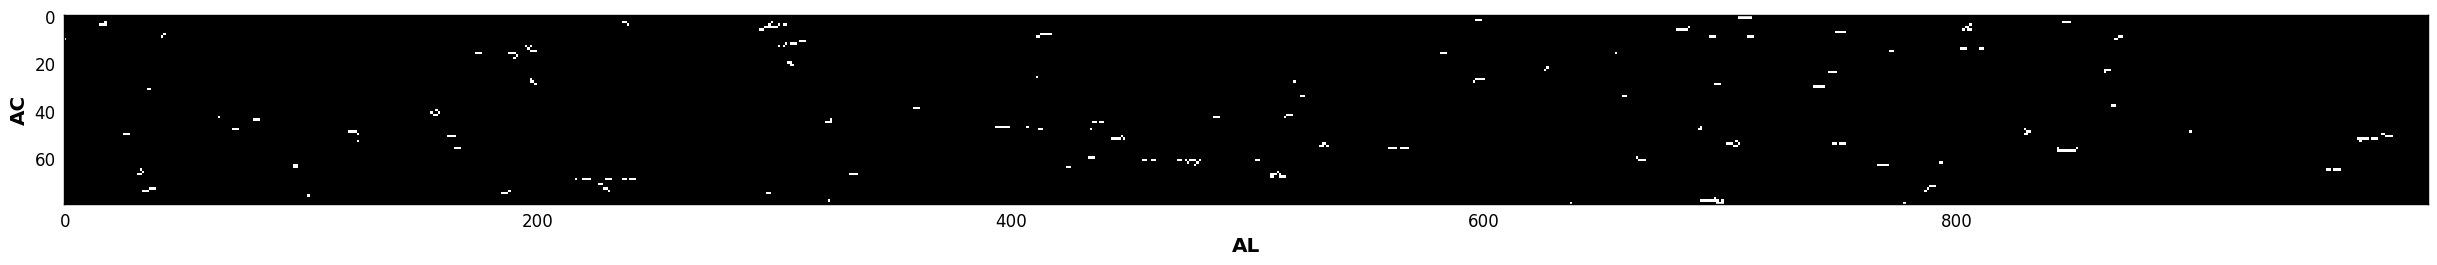

In [676]:
# treating neighbours
mask=(np.copy(stest)).astype('bool')

mask = astroscrappy.dilate3(mask)
mask = np.logical_and(S > sigclip, mask)

sigfrac = 0.3

# dilation - do this a few times
for ii in range(10):
    newmask = astroscrappy.dilate3(mask)
    newmask = np.logical_and(S > sigfrac*sigclip, newmask)
    if (newmask==mask).all():
        break
    else:
        mask = newmask

image=np.rot90(mask,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.grid(False)

In [677]:
cosmics = mask*signal # we've essentially already subtracted the background, right?

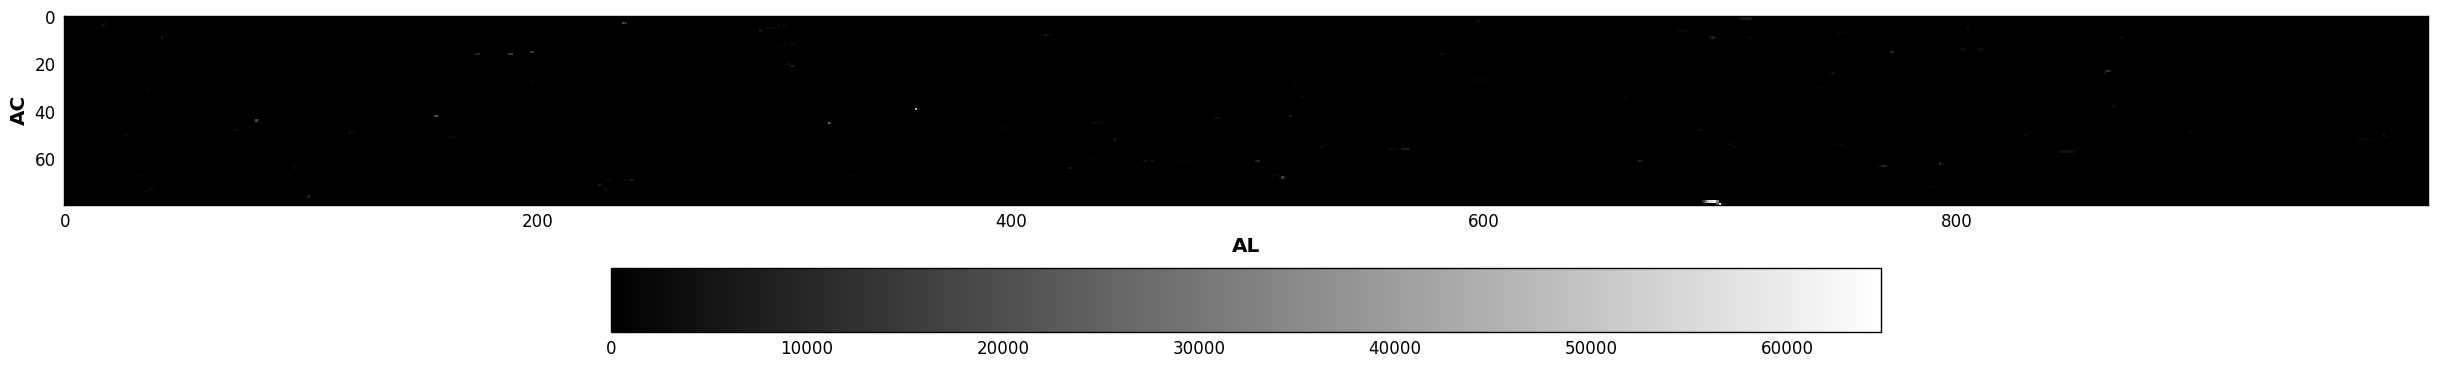

In [678]:
image=np.rot90(cosmics,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

In [679]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask,structure=(np.ones((3,3))))
#(labels, ntracks) = ndimage.measurements.label(mask,structure=[[0,1,0],[1,1,1],[0,1,0]])
#(labels, ntracks) = ndimage.measurements.label(dilmask,structure=[[0,1,0],[1,1,1],[0,1,0]])

# object extraction based on labels
events = ndimage.measurements.find_objects(labels)

print("Number of events:", ntracks)

Number of events: 108


# Energies

In [680]:
# Extract track electron count

events_e = np.zeros(ntracks)

for ii in range(ntracks):
    events_e[ii] = np.sum(cosmics[events[ii]])

Min: 410.3445
Max: 404250.338333


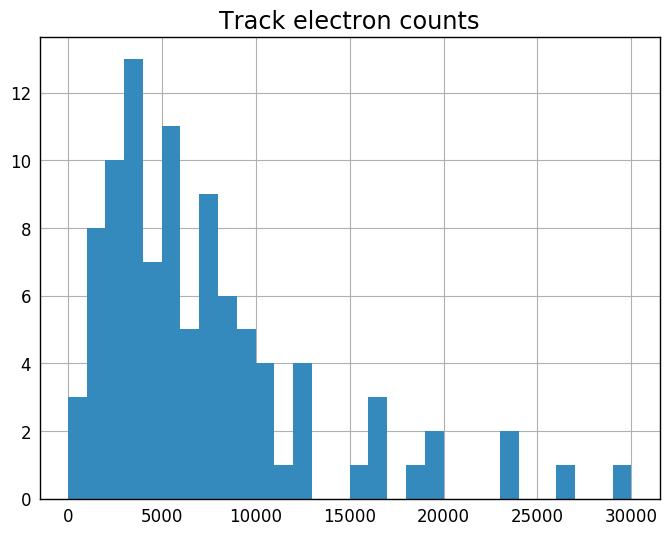

In [681]:
#ehist = plt.hist(events_e,100,log=True)
ehist = plt.hist(events_e,30,range=(0,30000)) # cut off the maximum energies - I want a comparison with
                                              # the simulator validation presentation
plt.title("Track electron counts")
print('Min:',np.min(events_e))
print('Max:',np.max(events_e))

-> this is remarkably similar to the spectrum from the SIF-files!

# Error estimation

In [682]:
# Extract track electron count error

err_cts = err_mean*mask      # energies are only extracted from masked regions
err_e = np.zeros(ntracks)

for ii in range(ntracks):
    err_e[ii] = np.sqrt(np.sum(err_cts[events[ii]]**2))

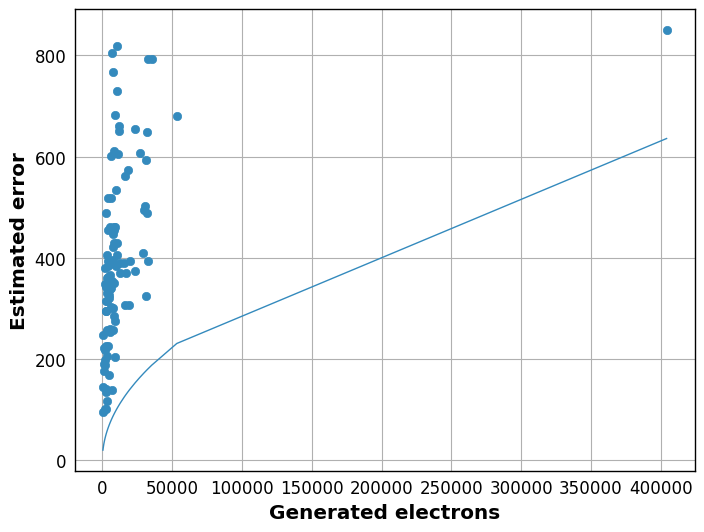

In [683]:
plt.scatter(events_e, err_e)
plt.plot(np.sort(events_e), np.sqrt(np.sort(events_e)))
#plt.xlim(0,50000)

plt.ylabel("Estimated error")
plt.xlabel("Generated electrons")

-> The error is now much more than Poisson - I presume due to the larger background.

Minimum SNR: 1.92343545615


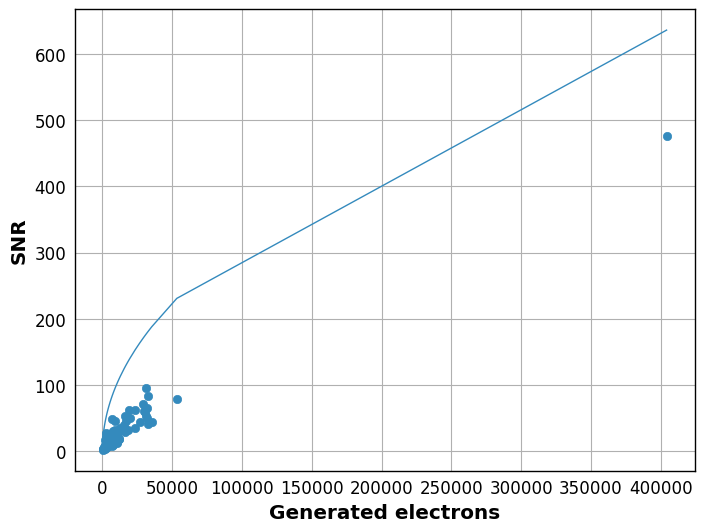

In [684]:
plt.scatter(events_e, events_e/err_e)
plt.plot(np.sort(events_e), np.sqrt(np.sort(events_e)))
#plt.xlim(0,50000)

plt.ylabel("SNR")
plt.xlabel("Generated electrons")

print("Minimum SNR:", np.min(events_e/err_e))

-> Still, the minimum SNR is very acceptable - way above 1

# Track lengths

In [685]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)
lx = np.zeros(ntracks)
ly = np.zeros(ntracks)

covered = 0   # amount of cosmic pixels

for ii in range(ntracks):
    # unit: \mu m
    dx = events[ii][0].stop-events[ii][0].start
    dy = events[ii][1].stop-events[ii][1].start

    lx[ii] = (dx-1)*10               # to roughly account for the binning
    ly[ii] = (dy-1)*120              # need to subtract 1, since single pixel cosmics would then have
                                     # a length of sqrt(2)
    covered += dx*dy

lengths = np.sqrt(lx**2 + ly**2)
#lhist = plt.hist(lengths,30)
#plt.title("Track Lengths")

In [686]:
print("Covered fraction of image:", covered/source.shape[0]/source.shape[1]*100, "%")

Covered fraction of image: 0.75 %


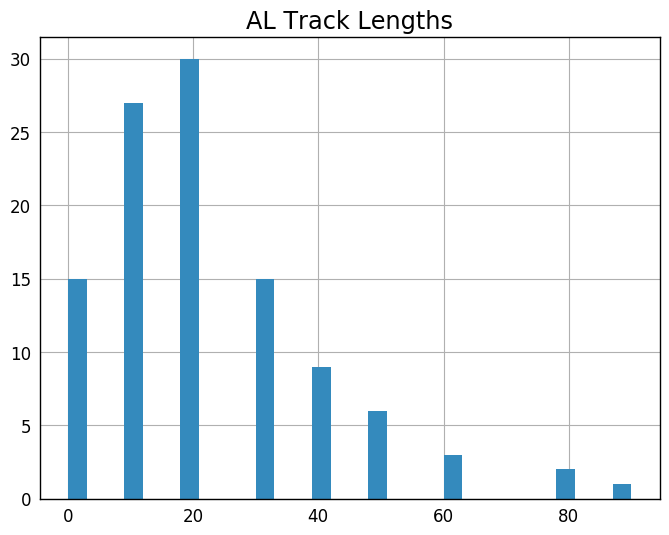

In [687]:
xhist = plt.hist(lx,30)
plt.title("AL Track Lengths")

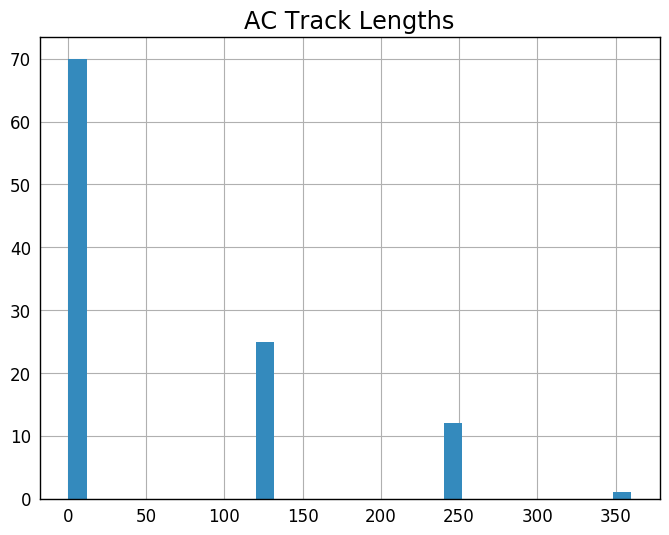

In [688]:
yhist = plt.hist(ly,30)
plt.title("AC Track Lengths")

In [689]:
theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 5000  # 90
theta[ly==0] = 5000  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

Let's figure out the cosmic orientation

In [690]:
# if the UPPER LEFT CORNER of the event has a cosmic, it faces downwards
# this only works for cosmics that have angles not 0 or 90 deg
for ii in range(len(lx)):
    if (lx*ly)[ii]!=0:
        if mask[events[ii]][0,0]==1:
            theta[ii] *= -1

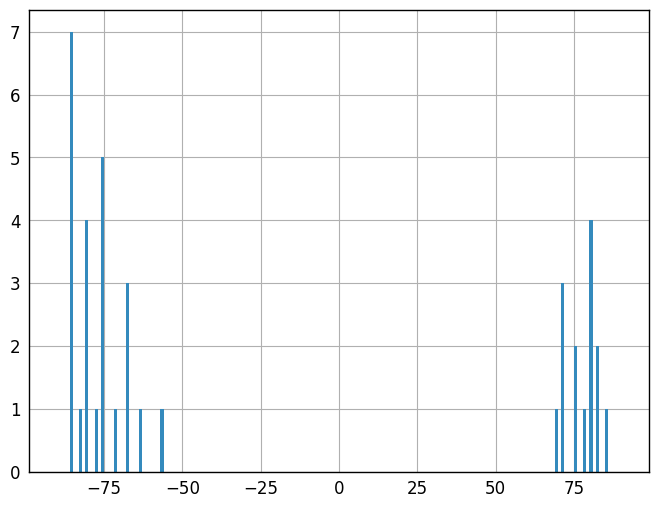

In [691]:
thist = plt.hist(theta,180,range=(-90,90))

# What if we just did median filtering?

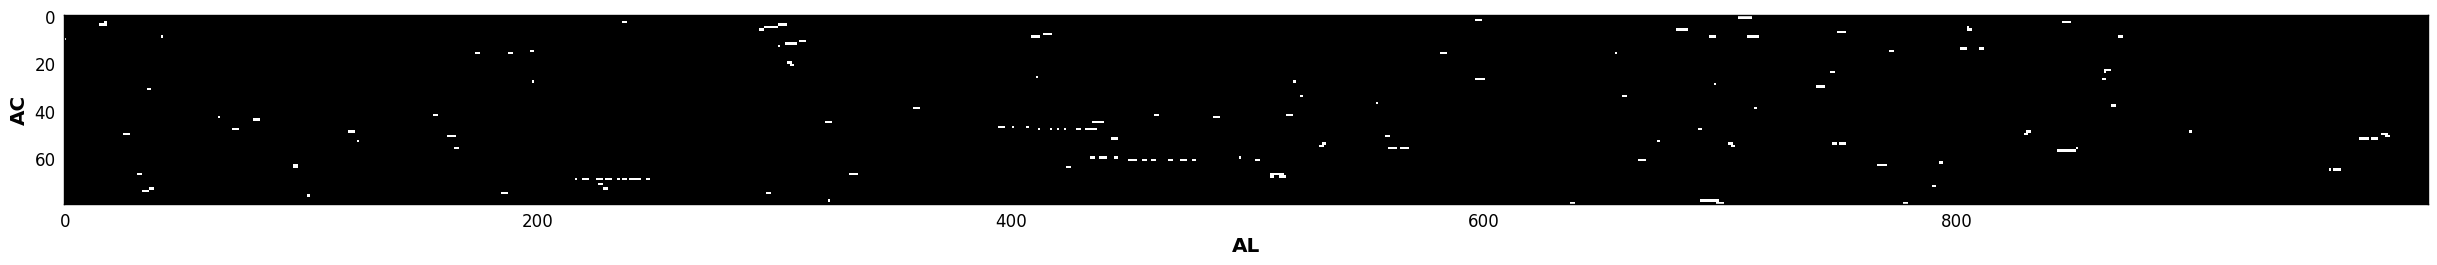

In [692]:
medmask = np.zeros(patterns[boxrad].shape)
SN = signal/noise

threshold = 4
medmask[SN > threshold] = 1


image=np.rot90(medmask,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

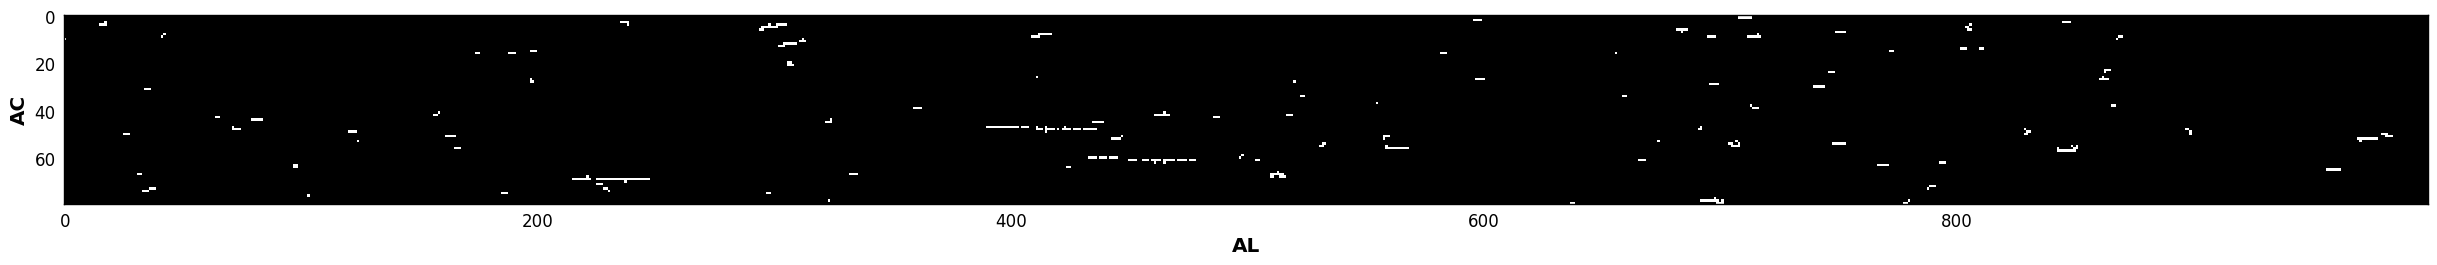

In [693]:
# treating neighbours
medmask=medmask.astype('bool')
threshfrac = 0.45

medmask = astroscrappy.dilate3(medmask)
medmask = np.logical_and(SN > threshold, medmask)

# dilation - do this a few times
for ii in range(10):
    newmask = astroscrappy.dilate3(medmask)
    newmask = np.logical_and(SN > threshfrac*threshold, newmask)
    if (newmask==medmask).all():
        break
    else:
        medmask = newmask


image=np.rot90(medmask,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.grid(False)

From a visual comparison, quite similar. Gotta play around with sigclip/threshold, but since we don't have stars here, this might actually be fine!

(Best would be to compare performance, since we'll be processing > 10 Million of these images)

In [694]:
mask = medmask

In [695]:
cosmics = mask*signal # we've essentially already subtracted the background, right?

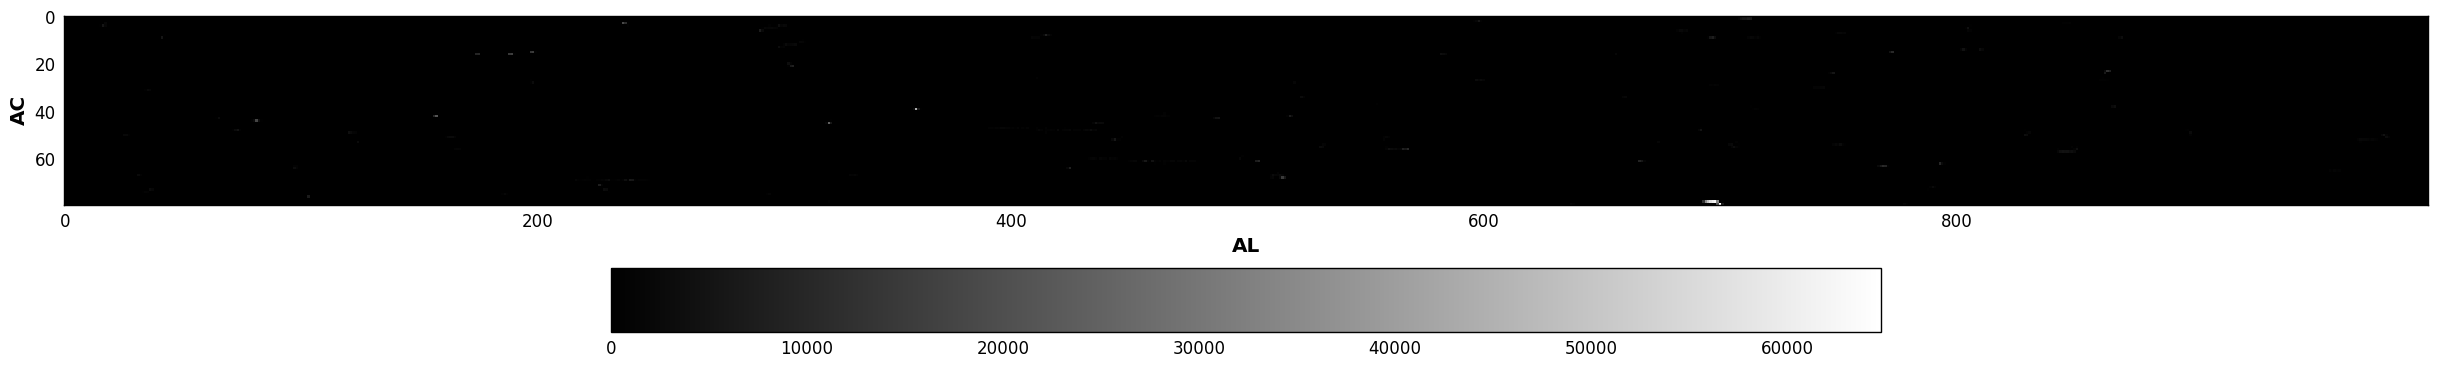

In [696]:
image=np.rot90(cosmics,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

In [697]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask,structure=(np.ones((3,3))))
#(labels, ntracks) = ndimage.measurements.label(mask,structure=[[0,1,0],[1,1,1],[0,1,0]])
#(labels, ntracks) = ndimage.measurements.label(dilmask,structure=[[0,1,0],[1,1,1],[0,1,0]])

# object extraction based on labels
events = ndimage.measurements.find_objects(labels)

print("Number of events:", ntracks)

Number of events: 111


# Energies

In [698]:
# Extract track electron count

events_e = np.zeros(ntracks)

for ii in range(ntracks):
    events_e[ii] = np.sum(cosmics[events[ii]])

Min: 410.3445
Max: 404250.338333


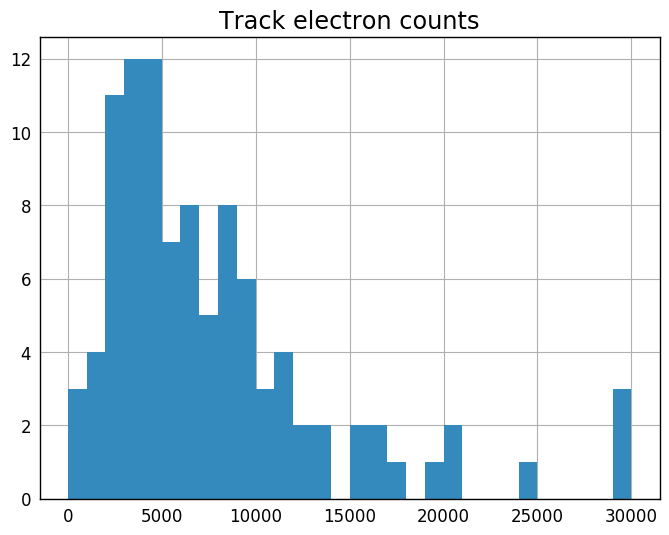

In [699]:
#ehist = plt.hist(events_e,100,log=True)
ehist = plt.hist(events_e,30,range=(0,30000)) # cut off the maximum energies - I want a comparison with
                                              # the simulator validation presentation
plt.title("Track electron counts")
print('Min:',np.min(events_e))
print('Max:',np.max(events_e))

# What is our limiting resolution anyway?

In [700]:
print("Maximum of noise:", np.max(noise), "e-")

Maximum of noise: 513.682587349 e-


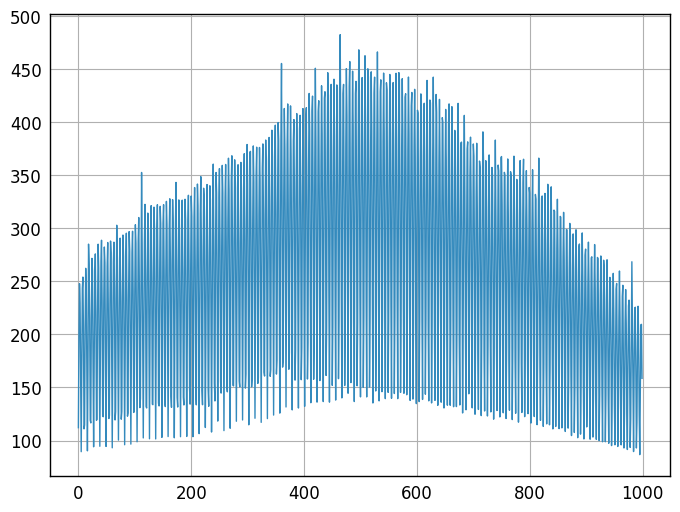

In [701]:
plt.plot(noise[:,40])

-> So the noise is up to about 500 e-, but varies in the pattern by a factor of about 4!

Setting our threshold to 4 x noise, this sets us to 400-2000 e-/pixel...

Any cosmics with significant length in AL may be affected by this, especially the weaker ones.